## FORECASTING BRAZIL'S TRADE BALANCE: A SARIMAX APPROACH ##

In this project, I use SARIMA/SARIMAX methods to create a forecasting model for Brazil's net trade balance with the world. The main data ("sarimadatacomplete.csv") has the following categories:

1. Commodity Price Index (CPI, indep.): A simple average of international market prices for soy, petrol, corn and meat (USD / unit of weight)
2. Balance of trade (b_trade, dep.): Net trade balance in USD millions
3. USD/BRL rate of exchage (xchange_rate, indep.): Monthly average of USD/BRL buy-side exchange rate

Variables range from 1995 to late 2025.

In [2]:
#packages
import pandas as pd
import numpy as np

In [3]:
#reading data and interpolating
df = pd.read_csv('sarimadatacomplete.csv', 
                 index_col='Date', 
                 parse_dates=True)

df2 = df.asfreq('MS')

#using interpollation to replace missing values w/ consistency 
df_clean = df2.interpolate(method='linear') 

df_clean = df_clean.fillna(method='bfill').fillna(method='ffill')

#just checking if filling worked
df_clean.isnull().sum()

C:\Users\Vinicius\AppData\Local\Temp\ipykernel_16000\1143133287.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean = df_clean.fillna(method='bfill').fillna(method='ffill')


CPI             0
b_trade         0
xchange_rate    0
dtype: int64

## SARIMA forecast for CPI ##

To forecast future values for our dependent variable, we first need to come up with reliable values for our dependent variables.

First, I use a simpler forecasting method to come up with CPI values.

In [6]:
#ADF test (quant)
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df_clean['CPI']) 
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1]) 

ADF Statistic: -1.887799
p-value: 0.337822


As one might expected, commodity prices are quite seasonal (non-stationary) and have a general trend of growth. This warrants our SARIMA approach.

Now I apply an automated algorithm (ACI) to decide the most fitted parametres, adding some constraints to q,d and D to speed up testing.

In [5]:
#package w/ no update warnings
from pmdarima import auto_arima
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#ACI for to recommend a method
stepwise_fit = auto_arima(df_clean['CPI'],start_p=0, start_q=0,max_p=5, max_q=5,m=12, seasonal=True,d=1,start_P=0,start_Q=0,D=1,max_D=2,stepwise=True,suppress_warnings=True)

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  369
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -1278.077
Date:                            Sat, 22 Nov 2025   AIC                           2564.154
Time:                                    17:15:01   BIC                           2579.653
Sample:                                01-01-1995   HQIC                          2570.319
                                     - 09-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3387      0.039      8.737      0.000       0.263       0.415
ar.S.L12      -0.6440      0.039   

The algorithm outputs a SARIMA (1, 1, 0) x (2, 1, 0, 12). Now we can use these parametres to forecast prices six months from now.

**Running Individual SARIMA model for CPI**

In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train = df_clean.iloc[:363]
test = df_clean.iloc[363:]

model = SARIMAX(df_clean['CPI'], order = (1,1,0), seasonal_order = (2,1,0,12))
results = model.fit()

start = len(train)
end = len(train) + len(test) - 1

predictions = results.predict(start=start, end=end, typ = 'levels').rename('SARIMA CPI Predictions')

**Checking Results and forecasting**

RMSE:  5.529658527718547


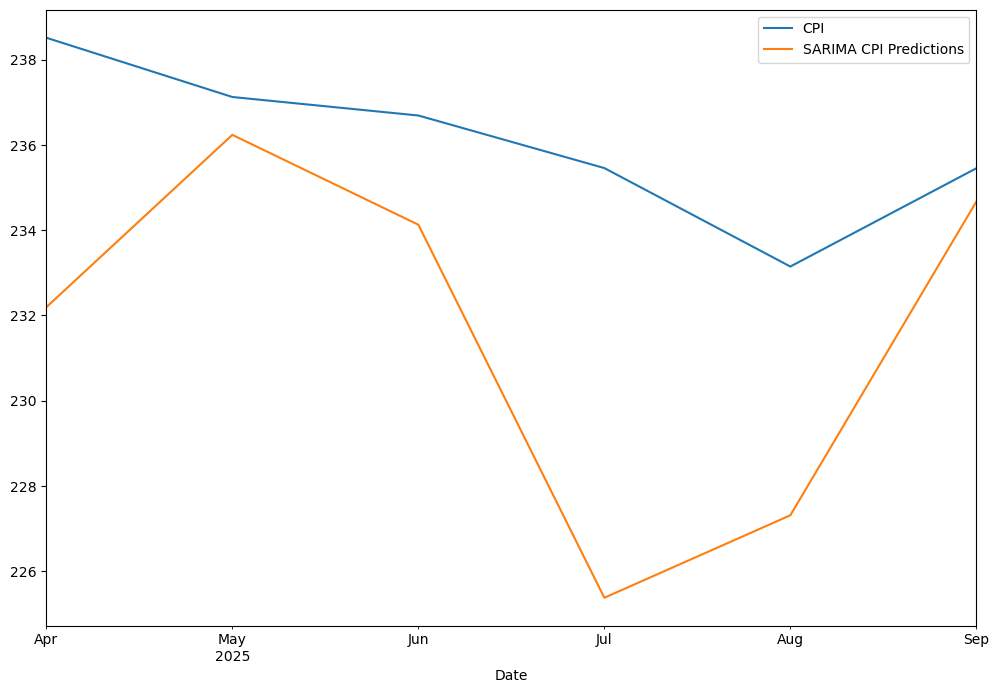

In [8]:
test['CPI'].plot(legend=True, figsize=(12,8))
predictions.plot(legend=True);

from sklearn.metrics import mean_squared_error
print('RMSE: ', np.sqrt(mean_squared_error(test['CPI'], predictions)))


Visually we look a little of, but for the purpose of this project, I'll consider a USD 5.52 RMSE as torelable.

Now we create a 6-month forecast.

In [9]:
cpi_fcast = results.get_forecast(steps = 6).predicted_mean
cpi_fcast.head()

2025-10-01    235.732662
2025-11-01    235.114325
2025-12-01    231.194938
2026-01-01    234.408774
2026-02-01    235.275869
Freq: MS, Name: predicted_mean, dtype: float64

## SARIMA forecast for USD/BRL exchange rate ##

No we must repeat the process for the USD/BRL exchange rate.

In [10]:
#Stationarity Tests
dftest = adfuller(df_clean['xchange_rate']) 
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])

ADF Statistic: -0.534045
p-value: 0.885200


Again, data is non-stationary, warranting our SARIMA approach

In [20]:
#finding best model
stepwise_fit = auto_arima(df_clean['xchange_rate'],start_p=0, start_q=0,max_p=5, max_q=5,m=12, seasonal=True,d=1,start_P=0,start_Q=0,D=1,max_D=2,stepwise=True,suppress_warnings=True)

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  369
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood                 103.222
Date:                            Fri, 21 Nov 2025   AIC                           -198.443
Time:                                    14:40:02   BIC                           -182.943
Sample:                                01-01-1995   HQIC                          -192.278
                                     - 09-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1451      0.035     -4.117      0.000      -0.214      -0.076
ar.S.L12      -0.6686      0.035   

**Running Individual SARIMA model for xchange rate**

In [11]:
model = SARIMAX(df_clean['xchange_rate'], order = (1,1,0), seasonal_order = (2,1,0,12))
results = model.fit()

start = len(train)
end = len(train) + len(test) - 1

predictions = results.predict(start=start, end=end, typ = 'levels').rename('SARIMA xcgange rate Predictions')

**Checking results**

RMSE:  0.1503649359109015


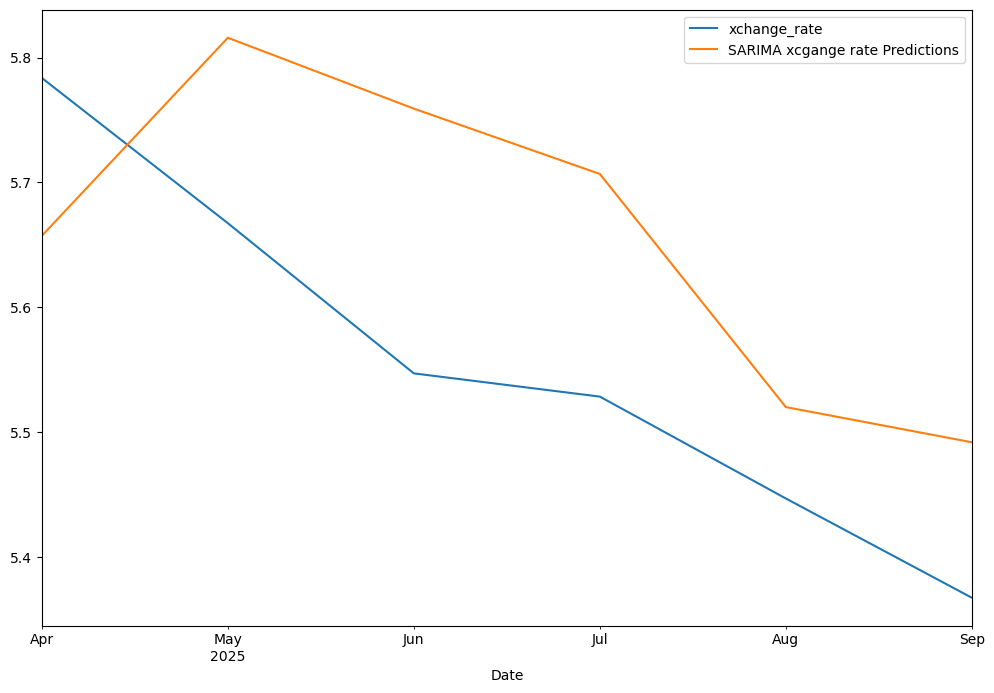

In [12]:
test['xchange_rate'].plot(legend=True, figsize=(12,8))
predictions.plot(legend=True);

from sklearn.metrics import mean_squared_error
print('RMSE: ', np.sqrt(mean_squared_error(test['xchange_rate'], predictions)))

I'll consider less than one USD as a toreable margin of error (RMSE) for the purpose of this project.

In [13]:
xrate_fcast = results.get_forecast(steps = 6).predicted_mean
xrate_fcast.head()

2025-10-01    5.427404
2025-11-01    5.467956
2025-12-01    5.553897
2026-01-01    5.521462
2026-02-01    5.445785
Freq: MS, Name: predicted_mean, dtype: float64

# Final SARIMAX model for forecasting Trade Balance #

With both CPI and exhchange rate predictions, we can input them in the overall SARIMAX forecast for our trade balance.

We just need to merge the predictions w/ our original dataset. 

In [14]:
#xchangerate and cpi
xrate_cpi = pd.concat([xrate_fcast, cpi_fcast], axis = 1)
xrate_cpi.columns = [['xchange_rate','CPI']]
xrate_cpi.index.name = 'Date'

#getting rid of tuple indexing
xrate_cpi.columns = xrate_cpi.columns.get_level_values(0)

In [15]:
df_clean = df_clean[['xchange_rate','CPI','b_trade']]
final_df = pd.concat([df_clean, xrate_cpi], axis = 0)

**Testing Stationarity**

In [17]:
dftest = adfuller(df_clean['b_trade']) 
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1]) 

ADF Statistic: -1.808532
p-value: 0.376234


**Choosing the model**

In [67]:
stepwise_fit = auto_arima(df_clean['b_trade'],start_p=0, start_q=0,max_p=5, max_q=5,m=12, seasonal=True,d=1,start_P=0,start_Q=0,D=1,max_D=3,stepwise=True,suppress_warnings=True)

print(stepwise_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  369
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -3066.375
Date:                            Fri, 21 Nov 2025   AIC                           6140.750
Time:                                    15:14:55   BIC                           6156.250
Sample:                                01-01-1995   HQIC                          6146.915
                                     - 09-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2945      0.060      4.941      0.000       0.178       0.411
ma.L1         -0.7923      0.039   

**Fitting the suggested model**

RMSE:  2128.345150497362


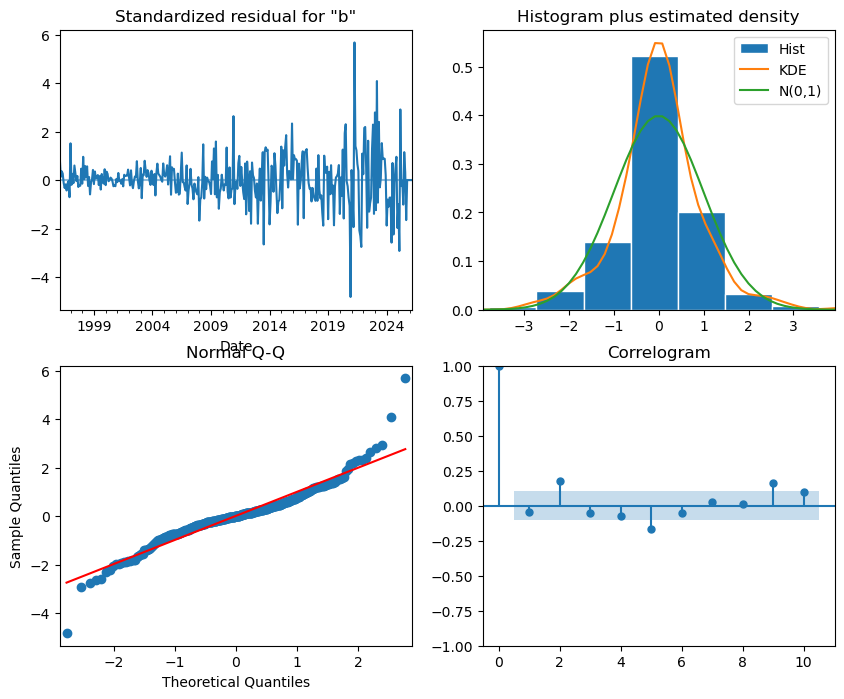

In [23]:
train = final_df.iloc[:360]
test = final_df.iloc[360:369]

exog_data = final_df[['CPI', 'xchange_rate']]
endog_data = final_df['b_trade']

model = SARIMAX(endog = endog_data, exog = exog_data, order = (1, 1, 1), seasonal_order = (0,1,1,12))
results = model.fit()

start = len(train)
end = len(train) + len(test) - 1

results.plot_diagnostics(figsize=(10, 8));

print('RMSE: ', np.sqrt(mean_squared_error(test['b_trade'], predictions)))

Some things are off:
1. A USD 2128.34 margin of error is too high for the scale of our variable. There's some variance that the model is not capturing
2. By our correlogram, lags 2, 5 and 11 are not well ajusted yet.

The lags could be fixed manually, but the inaccuary points to a structural issue with the SARIMAX.

**The main hypothesis**

By mid-2025, a series of tarrifs were imposed on Brazil by the US, one of the country's largest trading partners. Indeed, we can see a sharp drop in the trade balance after July-August.

<Axes: xlabel='Date'>

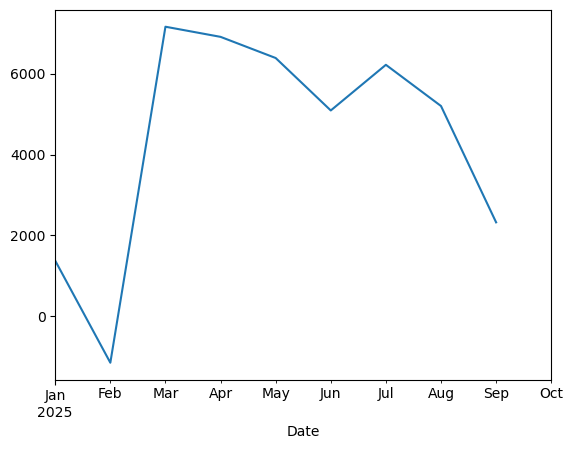

In [91]:
final_df['b_trade']['2025-01-01':'2025-10-01'].plot()

Since trade takes longer to be re-directed to other import partners (thus, a lagged relationship) the model might be unable to deal with this exogenous shock in its current form.

A future project could deal with the issue, but this one ends here.